# Transfer learning part 2: Fine-tuning

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from imageio.v2 import imread
import tensorflow as tf
tf.random.set_seed(42)

In [2]:
train_dir = "/content/drive/MyDrive/Colab_data/food/train"
test_dir = "/content/drive/MyDrive/Colab_data/food/test"

In [3]:
IMG_HEIGHT, IMG_WIDTH, CHANNELS = 224, 224, 3

In [4]:
train_data = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                         labels = 'inferred',
                                                         label_mode = 'int',
                                                         color_mode = 'rgb',
                                                         validation_split = 0.8,
                                                         seed = 222,
                                                         subset = 'training',
                                                         image_size = (IMG_HEIGHT, IMG_WIDTH),
                                                         batch_size = 32)
valid_data = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                         labels = 'inferred',
                                                         label_mode = 'int',
                                                         color_mode = 'rgb',
                                                         validation_split = 0.8,
                                                         seed = 222,
                                                         subset = 'validation',
                                                         image_size = (IMG_HEIGHT, IMG_WIDTH),
                                                         batch_size = 32)
test_data = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                         labels = 'inferred',
                                                         label_mode = 'int',
                                                         color_mode = 'rgb',
                                                         image_size = (IMG_HEIGHT, IMG_WIDTH),
                                                         batch_size = 32)

Found 4827 files belonging to 7 classes.
Using 966 files for training.
Found 4827 files belonging to 7 classes.
Using 3861 files for validation.
Found 1613 files belonging to 7 classes.


In [5]:
class_names = train_data.class_names

## Visualize data

We use the same functions we used in previous notebooks. We could potentially create a python package/module to load from!

In [ ]:
def visualize_single_image(dirpath: str, ax: np.ndarray =None) -> None:
  ''' Visualizes a single random image from a directory of images '''
  classes = os.listdir(dirpath)
  class_choice = np.random.randint(0, len(classes), 1)[0] # Pick a random class
  images = os.listdir(os.path.join(dirpath,classes[class_choice])) # get a list of all images in the class directory
  img_choice = np.random.randint(0, len(images), 1)[0] # Pick a random image
  image = imread(os.path.join(os.path.join(dirpath,classes[class_choice]),images[img_choice])) #load the image
  if ax is None:
    fig, ax = plt.subplots()
  ax.imshow(image) # visualize the image
  ax.set_title(f'{classes[class_choice]}') # Add class name as the title
  ax.set_axis_off()

def create_img_grid(dirpath: str, num_of_imgs: int) -> None:
  ''' Create a grid of images from a directory '''

  # Get number of rows and columns for the image grid
  n_rows = int(np.sqrt(num_of_imgs))
  if (num_of_imgs % n_rows):
    n_cols = n_rows + 1
  else:
    n_cols = n_rows

  size_factor = 2 # length/height of each image

  # Create a grid and visualize the images on the grid
  fig, ax = plt.subplots(n_rows, n_cols, figsize=(size_factor*n_rows, size_factor*n_cols))
  ax_flat = ax.flatten()
  for i in range(num_of_imgs):
    visualize_single_image(dirpath, ax = ax_flat[i])

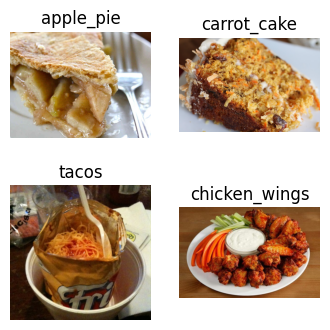

In [ ]:
create_img_grid(train_dir, 4)

## Perform classification using Sequential API

Using Keras Hub has issues with the new tensorflow as it uses Keras 3.0 instead of 2.0. Therefore, in previous notebooks, I used the functional API.
Going through the Tensorflow documentation, however, I found the proper way to do feature extraction using Sequential API. I test that here

In [ ]:
# Load a convolutional base with pre-trained weights
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top = False,
                                                               weights = 'imagenet',
                                                               input_shape = (IMG_HEIGHT, IMG_WIDTH, CHANNELS),
                                                               pooling = 'avg')

# Freeze the base model
base_model.trainable = False

# Use a Sequential model to add a trainable classifier on top
model_0 = tf.keras.Sequential([
    tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
    tf.keras.layers.RandomContrast((0,1)),
    tf.keras.layers.RandomRotation(0.1),
    base_model,
    tf.keras.layers.Dense(7, activation= 'softmax'),
])

model_0.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
model_0.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_contrast (RandomContrast)     │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 1280)                │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │           8,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,076,474 (15.55 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 17,936 (70.07 KB)

In [ ]:
# Configure data to optimize model performance
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.cache().prefetch(buffer_size=AUTOTUNE)

# Train model
history_0 = model_0.fit(train_data, epochs = 10, validation_data = valid_data)

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1892s 63s/step - accuracy: 0.4087 - loss: 1.6618 - val_accuracy: 0.6814 - val_loss: 1.1103
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 344ms/step - accuracy: 0.7261 - loss: 1.0247 - val_accuracy: 0.7410 - val_loss: 0.8628
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 350ms/step - accuracy: 0.7608 - loss: 0.8268 - val_accuracy: 0.7687 - val_loss: 0.7635
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 411ms/step - accuracy: 0.7833 - loss: 0.7449 - val_accuracy: 0.7786 - val_loss: 0.7074
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 18s 339ms/step - accuracy: 0.8226 - loss: 0.6421 - val_accuracy: 0.7874 - val_loss: 0.6730
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 339ms/step - accuracy: 0.8260 - loss: 0.5969 - val_accuracy: 0.7902 - val_loss: 0.6491
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 344ms/step - accuracy: 0.8425 - loss: 0.5671 - val_accuracy: 0.7923 - val_loss: 0.6361
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 345ms/step - accuracy: 0.8552 - loss: 0.5134 - val_accu

In [ ]:
test_loss, test_acc = model_0.evaluate(test_data)

51/51 ━━━━━━━━━━━━━━━━━━━━ 647s 13s/step - accuracy: 0.7975 - loss: 0.6196


## Going back to Functional API

In [ ]:
def augmentator(data):
  aug_layer = tf.keras.Sequential([
      tf.keras.layers.RandomContrast((0,1)),
      tf.keras.layers.RandomRotation(0.1)
  ])

  return aug_layer(data)

def create_base_model(num_of_classes, img_height, img_width, color_mode):
  ''' Create a feature extraction model based on EfficientNetB0 '''

  inputs = tf.keras.Input(shape = (img_height, img_width, color_mode))

  # Data augmentation layer
  x = augmentator(inputs)

  # Load a convolutional base with pre-trained weights
  base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top = False,
                                                                weights = 'imagenet',
                                                                input_shape = (img_height, img_width, color_mode),
                                                                pooling = 'avg')

  # Freeze the base model
  base_model.trainable = False
  # pass data to base model
  x = base_model(x, training=False)

  # Create output layer
  if num_of_classes == 2:
    prediction_layer = tf.keras.layers.Dense(num_of_classes-1, activation='sigmoid')
  else:
    prediction_layer = tf.keras.layers.Dense(num_of_classes, activation='softmax')
  # Pass data through output layer
  outputs = prediction_layer(x)

  # Create model
  model = tf.keras.Model(inputs, outputs)
  return model

In [ ]:
model_1 = create_base_model(len(class_names), IMG_HEIGHT, IMG_WIDTH, CHANNELS)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
model_1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 1280)                │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │           8,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,058,538 (15.48 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
model_1.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [ ]:
# Configure data to optimize model performance
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.cache().prefetch(buffer_size=AUTOTUNE)

# Train model
history_1 = model_1.fit(train_data, epochs = 10, validation_data = valid_data)

Epoch 1/10
 1/31 ━━━━━━━━━━━━━━━━━━━━ 13:44 27s/step - accuracy: 0.1250 - loss: 2.1880

In [ ]:
def plot_history(tf_history):
  ''' Plot loss and accuracy history for a model using Tensorflow history '''
  # Loss
  plt.figure()
  plt.plot(tf_history.epoch, tf_history.history['loss'], label='train')
  plt.plot(tf_history.epoch, tf_history.history['val_loss'], label = 'validation')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend()
  # Accuracy
  plt.figure()
  plt.plot(tf_history.epoch, tf_history.history['accuracy'], label='train')
  plt.plot(tf_history.epoch, tf_history.history['val_accuracy'], label = 'validation')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend()

In [ ]:
plot_history(history_1)

**The feature extraction name of the above transfer learning comes from the fact that the output of the model is a feature vector. The feature vector contains the learned patterns of the model based on a specific dataset**

Let's try a more severe data augmentation to see if we can make the model more generalizable

In [6]:
def augmentator(data):
  aug_layer = tf.keras.Sequential([
      tf.keras.layers.RandomContrast((0,1)),
      tf.keras.layers.RandomRotation(0.4),
      tf.keras.layers.RandomZoom(0.2),
      tf.keras.layers.RandomShear(x_factor=0.2, y_factor=0.2)
  ])

  return aug_layer(data)

def create_base_model_2(num_of_classes, img_height, img_width, color_mode):
  ''' Create a feature extraction model based on EfficientNetB0 '''

  inputs = tf.keras.Input(shape = (img_height, img_width, color_mode))

  # Data augmentation layer
  x = augmentator(inputs)

  # Load a convolutional base with pre-trained weights
  base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top = False,
                                                                weights = 'imagenet',
                                                                input_shape = (img_height, img_width, color_mode),
                                                                pooling = 'avg')

  # Freeze the base model
  base_model.trainable = False
  # pass data to base model
  x = base_model(x, training=False)

  # Create output layer
  if num_of_classes == 2:
    prediction_layer = tf.keras.layers.Dense(num_of_classes-1, activation='sigmoid')
  else:
    prediction_layer = tf.keras.layers.Dense(num_of_classes, activation='softmax')
  # Pass data through output layer
  outputs = prediction_layer(x)

  # Create model
  model = tf.keras.Model(inputs, outputs)
  return model

Let's create some checkpoints in case we have to run the code for longer as we apply harsher augmentation

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/fine_tune_checkpoint.weights.h5", monitor='val_loss', save_weights_only=True ,save_best_only=True)

In [ ]:
model_2 = create_base_model_2(len(class_names), IMG_HEIGHT, IMG_WIDTH, CHANNELS)

In [ ]:
model_2.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [ ]:
# Configure data to optimize model performance
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.cache().prefetch(buffer_size=AUTOTUNE)

# Train model
history_2 = model_2.fit(train_data, epochs = 10, validation_data = valid_data, validation_steps = int(len(valid_data)/4), callbacks=[checkpoint_callback])

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 482ms/step - accuracy: 0.2636 - loss: 1.8341 - val_accuracy: 0.5656 - val_loss: 1.3342
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 300ms/step - accuracy: 0.6498 - loss: 1.1930 - val_accuracy: 0.6823 - val_loss: 1.0503
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 224ms/step - accuracy: 0.7018 - loss: 0.9526 - val_accuracy: 0.7167 - val_loss: 0.9229
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.7400 - loss: 0.8496 - val_accuracy: 0.7250 - val_loss: 0.8745
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 260ms/step - accuracy: 0.7438 - loss: 0.8034 - val_accuracy: 0.7417 - val_loss: 0.8214
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 295ms/step - accuracy: 0.7745 - loss: 0.7335 - val_accuracy: 0.7531 - val_loss: 0.7841
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.7816 - loss: 0.7018 - val_accuracy: 0.7615 - val_loss: 0.7671
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 241ms/step - accuracy: 0.7809 - loss: 0.6712 - val_accuracy:

In [ ]:
#Evaluate model_2
model_2.evaluate(valid_data)

121/121 ━━━━━━━━━━━━━━━━━━━━ 302s 3s/step - accuracy: 0.7672 - loss: 0.7313


[0.7038349509239197, 0.7697487473487854]

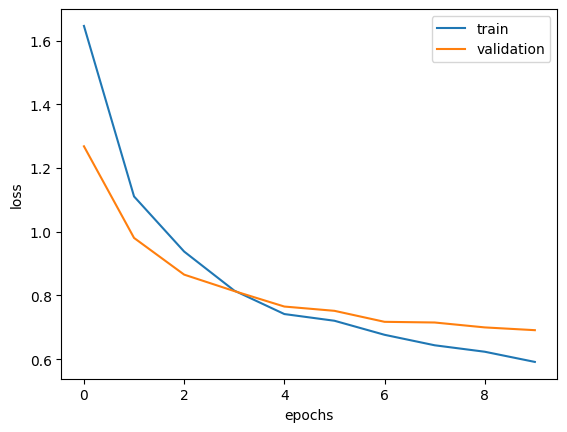

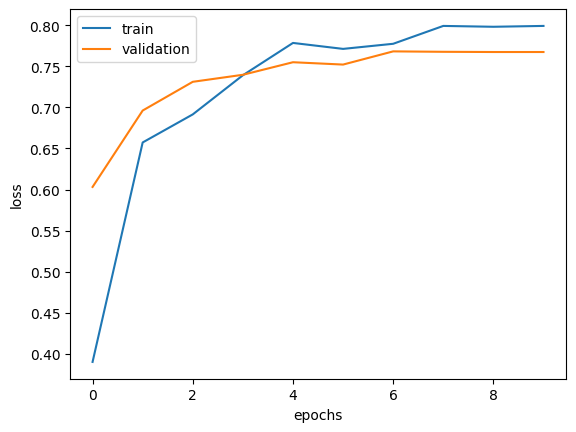

In [ ]:
plot_history(history_2)

Appears that `tf.keras.models.load_model` has issues with using a separate function for the autmentation layer. For now I save only weights and then test if I move the layer inside the model function to see if it works

In [7]:
saved_model = create_base_model_2(len(class_names), IMG_HEIGHT, IMG_WIDTH, CHANNELS)

saved_model.load_weights("/content/drive/MyDrive/Colab Notebooks/fine_tune_checkpoint.weights.h5")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
saved_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [9]:
saved_model.evaluate(test_data)

51/51 ━━━━━━━━━━━━━━━━━━━━ 305s 6s/step - accuracy: 0.7666 - loss: 0.7008


[0.7110669016838074, 0.7513949275016785]

## Fine-tuning

In [ ]:
model_2.layers

[<InputLayer name=input_layer, built=True>,
 <Sequential name=sequential, built=True>,
 <Functional name=efficientnetb0, built=True>,
 <Dense name=dense, built=True>]

In [ ]:
for layer in model_2.layers:
  print(f"layer {layer} is trainable: {layer.trainable}")

layer <InputLayer name=input_layer, built=True> is trainable: True
layer <Sequential name=sequential, built=True> is trainable: True
layer <Functional name=efficientnetb0, built=True> is trainable: False
layer <Dense name=dense, built=True> is trainable: True


In [ ]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer, layer.trainable)

0 <InputLayer name=input_layer_2, built=True> False
1 <Rescaling name=rescaling, built=True> False
2 <Normalization name=normalization, built=True> False
3 <Rescaling name=rescaling_1, built=True> False
4 <ZeroPadding2D name=stem_conv_pad, built=True> False
5 <Conv2D name=stem_conv, built=True> False
6 <BatchNormalization name=stem_bn, built=True> False
7 <Activation name=stem_activation, built=True> False
8 <DepthwiseConv2D name=block1a_dwconv, built=True> False
9 <BatchNormalization name=block1a_bn, built=True> False
10 <Activation name=block1a_activation, built=True> False
11 <GlobalAveragePooling2D name=block1a_se_squeeze, built=True> False
12 <Reshape name=block1a_se_reshape, built=True> False
13 <Conv2D name=block1a_se_reduce, built=True> False
14 <Conv2D name=block1a_se_expand, built=True> False
15 <Multiply name=block1a_se_excite, built=True> False
16 <Conv2D name=block1a_project_conv, built=True> False
17 <BatchNormalization name=block1a_project_bn, built=True> False
18 <Conv2

**To begin fine-tuning, unfreeze the last 10 layers of the base model**

In [20]:
def augmentator(data):
  aug_layer = tf.keras.Sequential([
      tf.keras.layers.RandomContrast((0,1)),
      tf.keras.layers.RandomRotation(0.4),
      tf.keras.layers.RandomZoom(0.2),
      tf.keras.layers.RandomShear(x_factor=0.2, y_factor=0.2)
  ])

  return aug_layer(data)

def create_base_model_2(num_of_classes, img_height, img_width, color_mode):
  ''' Create a feature extraction model based on EfficientNetB0 '''

  inputs = tf.keras.Input(shape = (img_height, img_width, color_mode))

  # Data augmentation layer
  x = augmentator(inputs)

  # Load a convolutional base with pre-trained weights
  base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top = False,
                                                                weights = 'imagenet',
                                                                input_shape = (img_height, img_width, color_mode),
                                                                pooling = 'avg')

  # Freeze the base model
  base_model.trainable = False
  # pass data to base model
  x = base_model(x, training=False)

  # Create output layer
  if num_of_classes == 2:
    prediction_layer = tf.keras.layers.Dense(num_of_classes-1, activation='sigmoid')
  else:
    prediction_layer = tf.keras.layers.Dense(num_of_classes, activation='softmax')
  # Pass data through output layer
  outputs = prediction_layer(x)

  # Create model
  model = tf.keras.Model(inputs, outputs)
  return model

In [16]:
def create_fine_tune_model(model, base_model_loc):
  ''' Create a feature extraction model based on EfficientNetB0 '''

  for layer in model.layers[base_model_loc].layers[-10:]:
    layer.trainable = True

  return model

**We first do feature extraction to find the last layer weights**

In [21]:
model_3 = create_base_model_2(7, IMG_HEIGHT, IMG_WIDTH, CHANNELS)

In [ ]:
for i, layer in enumerate(model_3.layers[2].layers):
  print(i, layer, layer.trainable)

0 <InputLayer name=input_layer_8, built=True> False
1 <Rescaling name=rescaling_4, built=True> False
2 <Normalization name=normalization_2, built=True> False
3 <Rescaling name=rescaling_5, built=True> False
4 <ZeroPadding2D name=stem_conv_pad, built=True> False
5 <Conv2D name=stem_conv, built=True> False
6 <BatchNormalization name=stem_bn, built=True> False
7 <Activation name=stem_activation, built=True> False
8 <DepthwiseConv2D name=block1a_dwconv, built=True> False
9 <BatchNormalization name=block1a_bn, built=True> False
10 <Activation name=block1a_activation, built=True> False
11 <GlobalAveragePooling2D name=block1a_se_squeeze, built=True> False
12 <Reshape name=block1a_se_reshape, built=True> False
13 <Conv2D name=block1a_se_reduce, built=True> False
14 <Conv2D name=block1a_se_expand, built=True> False
15 <Multiply name=block1a_se_excite, built=True> False
16 <Conv2D name=block1a_project_conv, built=True> False
17 <BatchNormalization name=block1a_project_bn, built=True> False
18 <C

In [22]:
model_3.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [23]:
history_3 = model_3.fit(train_data, epochs=5, validation_data=valid_data, validation_steps=int(len(valid_data)/4))

Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 189s 6s/step - accuracy: 0.2751 - loss: 1.8400 - val_accuracy: 0.6073 - val_loss: 1.2716
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 47s 787ms/step - accuracy: 0.6614 - loss: 1.1818 - val_accuracy: 0.7073 - val_loss: 0.9889
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 30s 410ms/step - accuracy: 0.7142 - loss: 0.9431 - val_accuracy: 0.7323 - val_loss: 0.8813
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 280ms/step - accuracy: 0.7555 - loss: 0.8296 - val_accuracy: 0.7167 - val_loss: 0.8629
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 320ms/step - accuracy: 0.7317 - loss: 0.7947 - val_accuracy: 0.7323 - val_loss: 0.8211


**Fine-tuning step**: undo the last 10 layers and fit the model for another 5 epochs

In [24]:
model_3 = create_fine_tune_model(model_3, 2)

In [ ]:
for i, layer in enumerate(model_3.layers[2].layers):
  print(i, layer, layer.trainable)

0 <InputLayer name=input_layer_8, built=True> False
1 <Rescaling name=rescaling_4, built=True> False
2 <Normalization name=normalization_2, built=True> False
3 <Rescaling name=rescaling_5, built=True> False
4 <ZeroPadding2D name=stem_conv_pad, built=True> False
5 <Conv2D name=stem_conv, built=True> False
6 <BatchNormalization name=stem_bn, built=True> False
7 <Activation name=stem_activation, built=True> False
8 <DepthwiseConv2D name=block1a_dwconv, built=True> False
9 <BatchNormalization name=block1a_bn, built=True> False
10 <Activation name=block1a_activation, built=True> False
11 <GlobalAveragePooling2D name=block1a_se_squeeze, built=True> False
12 <Reshape name=block1a_se_reshape, built=True> False
13 <Conv2D name=block1a_se_reduce, built=True> False
14 <Conv2D name=block1a_se_expand, built=True> False
15 <Multiply name=block1a_se_excite, built=True> False
16 <Conv2D name=block1a_project_conv, built=True> False
17 <BatchNormalization name=block1a_project_bn, built=True> False
18 <C

In [25]:
model_3.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

In [26]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/model_3_checkpoint.weights.h5", monitor='val_loss', save_weights_only=True ,save_best_only=True)

In [27]:
history_3_2 = model_3.fit(train_data, epochs=10, initial_epoch = history_3.epoch[-1], validation_data=valid_data, validation_steps=int(len(valid_data)/4), callbacks=[checkpoint_callback])

Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 25s 400ms/step - accuracy: 0.7710 - loss: 0.7921 - val_accuracy: 0.7552 - val_loss: 0.7744
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 321ms/step - accuracy: 0.8061 - loss: 0.6777 - val_accuracy: 0.7656 - val_loss: 0.7100
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 284ms/step - accuracy: 0.7874 - loss: 0.6832 - val_accuracy: 0.7635 - val_loss: 0.7047
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 677ms/step - accuracy: 0.8145 - loss: 0.6131 - val_accuracy: 0.7677 - val_loss: 0.6977
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 656ms/step - accuracy: 0.8319 - loss: 0.5596 - val_accuracy: 0.7760 - val_loss: 0.6816
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 696ms/step - accuracy: 0.8281 - loss: 0.5508 - val_accuracy: 0.7750 - val_loss: 0.6698


In [28]:
model_3.evaluate(valid_data)

121/121 ━━━━━━━━━━━━━━━━━━━━ 474s 4s/step - accuracy: 0.7798 - loss: 0.6611


[0.6316186189651489, 0.7837347984313965]

In [ ]:
def plot_histories(history_list):
  ''' Append list of histories for models with several fitting steps '''
  total_epochs = np.array([])
  total_loss = np.array([])
  total_val_loss = np.array([])
  total_acc = np.array([])
  total_val_acc = np.array([])

  # Concatenate histories
  for hist in history_list:
    total_epochs = np.append(total_epochs, hist.epoch)
    total_loss = np.append(total_loss, hist.history['loss'])
    total_val_loss = np.append(total_val_loss, hist.history['val_loss'])
    total_acc = np.append(total_acc, hist.history['loss'])
    total_val_acc = np.append(total_val_acc, hist.history['val_loss'])

  # Create 1D array for plotting
  total_epochs = total_epochs.flatten()
  total_loss = total_loss.flatten()
  total_val_loss = total_val_loss.flatten()
  total_acc = total_acc.flatten()
  total_val_acc = total_val_acc.flatten()

  # Plot Loss and accuracy plots
  plt.figure()
  plt.plot(total_epochs, total_loss, label='train')
  plt.plot(total_epochs, total_val_loss, label = 'validation')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()

  plt.figure()
  plt.plot(total_epochs, total_acc, label='train')
  plt.plot(total_epochs, total_val_acc, label = 'validation')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()

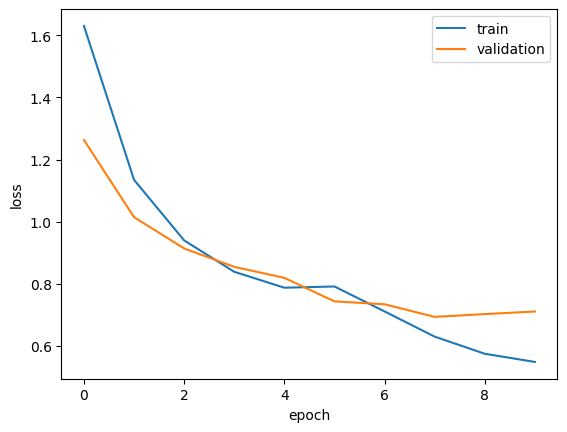

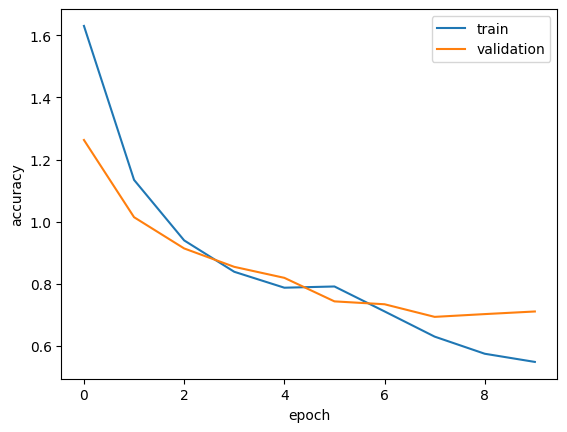

In [ ]:
plot_histories([history_3, history_3_2])

## Fine-tune on the entire data

In [10]:
all_train_data = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                         labels = 'inferred',
                                                         label_mode = 'int',
                                                         color_mode = 'rgb',
                                                         image_size = (IMG_HEIGHT, IMG_WIDTH),
                                                         batch_size = 32)

Found 4827 files belonging to 7 classes.


In [11]:
# Dataset optimization for performance
AUTOTUNE = tf.data.AUTOTUNE

all_train_data = all_train_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
model_4 = create_base_model_2(7, IMG_HEIGHT, IMG_WIDTH, CHANNELS)

In [13]:
model_4.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [14]:
# Use a smaller dataset for feature extraction
history_4 = model_4.fit(train_data, epochs=5)

Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 194s 6s/step - accuracy: 0.2912 - loss: 1.7994
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 120ms/step - accuracy: 0.6631 - loss: 1.1658
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.7027 - loss: 0.9533
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.7309 - loss: 0.8473
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.7962 - loss: 0.7154


In [17]:
model_4 = create_fine_tune_model(model_4, 2)

In [18]:
# Recompile model after changing layer properties. For fine-tuning, we use smaller learning rate to avoid losing previous training information.
model_4.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics = ['accuracy'])

In [29]:
# Use the entire dataset for fine-tuning
history_4_2 = model_4.fit(all_train_data, epochs=10, initial_epoch = history_3.epoch[-1])

Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 153ms/step - accuracy: 0.7167 - loss: 0.8697
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - accuracy: 0.7812 - loss: 0.6719
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.8049 - loss: 0.6098
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.8247 - loss: 0.5450
Epoch 9/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.8224 - loss: 0.5199
Epoch 10/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.8394 - loss: 0.4822


### Compare model performance for fine-tuned models

In [30]:
model_4.evaluate(test_data)

51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.8337 - loss: 0.4984


[0.4912870228290558, 0.8338499665260315]

In [ ]:
model_3.evaluate(test_data)

51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.7860 - loss: 0.6789


[0.6790036559104919, 0.7668939828872681]

**~7% better accuracy using larger dataset for fine-tuning**